<a href="https://colab.research.google.com/github/adinotfound11/ModelCounting/blob/main/Tic_tac_toe_Z3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install z3-solver

from z3 import *

board_size = 3
Cells = [[Int(f"Cell_{i}_{j}") for j in range(board_size)] for i in range(board_size)]
solver = Solver()

# Each cell can be 0 (empty), 1 (X), or 2 (O)
for i in range(board_size):
    for j in range(board_size):
        solver.add(Cells[i][j] >= 0, Cells[i][j] <= 2)

num_X = Sum([If(Cells[i][j] == 1, 1, 0) for i in range(board_size) for j in range(board_size)])
num_O = Sum([If(Cells[i][j] == 2, 1, 0) for i in range(board_size) for j in range(board_size)])

# The number of X's and O's should differ by at most 1, and X goes first
solver.add(num_X - num_O <= 1)
solver.add(num_O - num_X <= 0)

def is_winner(player_value):
    row_wins = [And([Cells[i][j] == player_value for j in range(board_size)]) for i in range(board_size)]
    col_wins = [And([Cells[i][j] == player_value for i in range(board_size)]) for j in range(board_size)]
    diag1_win = And([Cells[i][i] == player_value for i in range(board_size)])
    diag2_win = And([Cells[i][board_size - i - 1] == player_value for i in range(board_size)])
    return Or(*row_wins, *col_wins, diag1_win, diag2_win)

# Both players cannot win simultaneously
solver.add(Not(And(is_winner(1), is_winner(2))))

# If X wins, X has played one more move than O
solver.add(Implies(is_winner(1), num_X == num_O + 1))

# If O wins, X and O have played the same number of moves
solver.add(Implies(is_winner(2), num_X == num_O))

def count_moves_and_difficulty():
    total_moves = 0
    x_wins = 0
    o_wins = 0

    while solver.check() == sat:
        model = solver.model()

        x_win = is_winner(1)
        o_win = is_winner(2)

        if is_true(model.evaluate(x_win)):
            x_wins += 1
        if is_true(model.evaluate(o_win)):
            o_wins += 1

        total_moves += 1

        # Exclude the current model from future iterations
        current_model_constraints = []
        for i in range(board_size):
            for j in range(board_size):
                val = model.evaluate(Cells[i][j])
                current_model_constraints.append(Cells[i][j] == val)
        solver.add(Not(And(current_model_constraints)))

    return total_moves, x_wins, o_wins

total_moves, x_wins, o_wins = count_moves_and_difficulty()

print(f"Total number of valid configurations: {total_moves}")
print(f"Total number of X win options: {x_wins}")
print(f"Total number of O win options: {o_wins}")

if total_moves > 0:
    difficulty_o = 1 - (o_wins / total_moves)
    difficulty_x = 1 - (x_wins / total_moves)
else:
    difficulty_o = difficulty_x = None

print(f"Difficulty for O: {difficulty_o}")
print(f"Difficulty for X: {difficulty_x}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 33.2 MB/s eta 0:00:00
Total number of valid configurations: 5478
Total number of X win options: 626
Total number of O win options: 316
Difficulty for O: 0.9423147133990507
Difficulty for X: 0.8857247170500182



Testing grid size 2x4 with 4 moves...
Elapsed time: 0.09 seconds

Testing grid size 2x4 with 14 moves...
Elapsed time: 0.29 seconds

Testing grid size 3x5 with 5 moves...
Elapsed time: 0.25 seconds

Testing grid size 3x5 with 15 moves...
Elapsed time: 0.89 seconds

Testing grid size 4x6 with 6 moves...
Elapsed time: 0.80 seconds

Testing grid size 4x6 with 16 moves...
Elapsed time: 1.75 seconds

Testing grid size 5x7 with 7 moves...
Elapsed time: 0.84 seconds

Testing grid size 5x7 with 17 moves...
Elapsed time: 1.80 seconds

Testing grid size 6x40 with 40 moves...
Elapsed time: 157.87 seconds

Testing grid size 6x40 with 50 moves...
Elapsed time: 288.28 seconds
Grid 2x4 with 4 moves: 0.09 seconds
Grid 2x4 with 14 moves: 0.29 seconds
Grid 3x5 with 5 moves: 0.25 seconds
Grid 3x5 with 15 moves: 0.89 seconds
Grid 4x6 with 6 moves: 0.80 seconds
Grid 4x6 with 16 moves: 1.75 seconds
Grid 5x7 with 7 moves: 0.84 seconds
Grid 5x7 with 17 moves: 1.80 seconds
Grid 6x40 with 40 moves: 157.87 seco

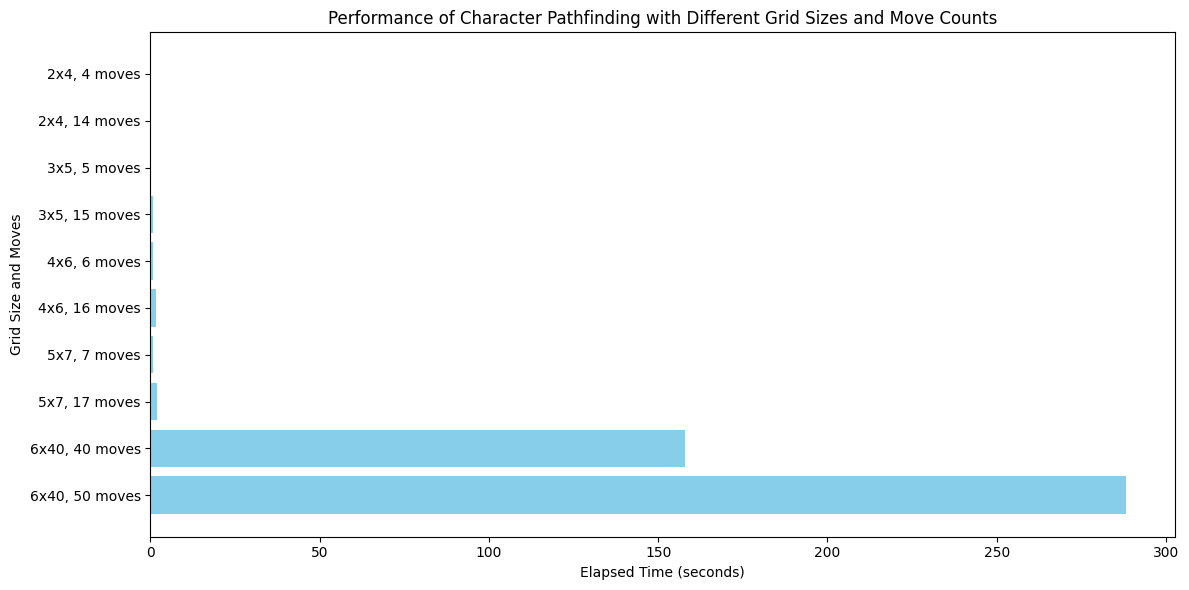

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
!pip install z3-solver

from z3 import *
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from IPython.display import HTML
import time
import random

# Define characters' movement abilities
movement_rules = {
    'Tank': [(0, 0), (0, -1), (0, 1)],       # Can stay or move left/right within the same row
    'Agility': [(0, 0), (0, -1), (0, 1),     # Can stay or move left/right
                (-1, 0), (1, 0)],            # Can move up/down
}

# Initialize a dictionary to hold variables and solvers for each character
characters = {}

# Function to initialize character variables
def initialize_character(name, rows, cols, moves):
    position_vars = [[[Bool(f"{name}_{i}_{j}_{t}") for t in range(moves + 1)]
                      for j in range(cols)] for i in range(rows)]
    solver = Solver()
    characters[name] = {
        'vars': position_vars,
        'solver': solver,
    }

# Function to add constraints for a character
def add_constraints(name, movement_directions, rows, cols, moves, initial_position, goal_position, enemy_positions, avoid_enemies=False):
    vars = characters[name]['vars']
    solver = characters[name]['solver']

    # Constraint 1: Start position at initial position at time 0
    solver.add(vars[initial_position[0]][initial_position[1]][0] == True)

    # Constraint 2: The character must be in exactly one position at each time step
    for t in range(moves + 1):
        solver.add(Sum([If(vars[i][j][t], 1, 0)
                        for i in range(rows) for j in range(cols)]) == 1)
        # If the character must avoid enemies, add constraints to avoid enemy positions
        if avoid_enemies:
            for (ei, ej) in enemy_positions:
                solver.add(vars[ei][ej][t] == False)

    # Constraint 3: Movement constraints based on allowed directions
    for t in range(1, moves + 1):
        for i in range(rows):
            for j in range(cols):
                previous_positions = []
                for dx, dy in movement_directions:
                    prev_i, prev_j = i + dx, j + dy
                    if 0 <= prev_i < rows and 0 <= prev_j < cols:
                        previous_positions.append(vars[prev_i][prev_j][t - 1])
                if previous_positions:
                    solver.add(Implies(vars[i][j][t], Or(previous_positions)))
                else:
                    solver.add(vars[i][j][t] == False)

    # Constraint 4: The character should reach the goal position in 'moves' moves or less
    goal_positions = [vars[goal_position[0]][goal_position[1]][t]
                      for t in range(moves + 1)]
    solver.add(Or(goal_positions))

# Function to find paths for a character
def find_paths(name, rows, cols, moves, max_paths=1):
    vars = characters[name]['vars']
    solver = characters[name]['solver']
    counter = 0
    paths = []
    local_solver = Solver()
    local_solver.add(solver.assertions())
    while local_solver.check() == sat:
        counter += 1
        model = local_solver.model()
        path = []
        for t in range(moves + 1):
            for i in range(rows):
                for j in range(cols):
                    if is_true(model.evaluate(vars[i][j][t])):
                        path.append((i, j))
                        break
        paths.append(path)
        # Exclude the current solution from future searches
        local_solver.add(Not(And([vars[i][j][t] == model.evaluate(vars[i][j][t])
                                  for i in range(rows) for j in range(cols)
                                  for t in range(moves + 1)])))
        if counter >= max_paths:
            break
    return paths

# Function to visualize paths using matplotlib animation
def visualize_paths(name, paths, rows, cols, symbol='C'):
    for idx, path in enumerate(paths, 1):
        fig, ax = plt.subplots(figsize=(cols, rows))
        ax.set_xlim(0, cols)
        ax.set_ylim(0, rows)
        ax.set_xticks(range(cols+1))
        ax.set_yticks(range(rows+1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True)
        ax.invert_yaxis()

        # Draw enemies
        enemy_patches = []
        for (ei, ej) in enemy_positions:
            rect = patches.Rectangle((ej, ei), 1, 1, linewidth=1, edgecolor='black', facecolor='red')
            enemy_patches.append(rect)
            ax.add_patch(rect)

        # Draw goal position
        goal_rect = patches.Rectangle((goal_position[1], goal_position[0]), 1, 1, linewidth=2, edgecolor='green', facecolor='none', linestyle='--')
        ax.add_patch(goal_rect)

        # Character patch
        character_patch = patches.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='black', facecolor='blue')
        ax.add_patch(character_patch)

        def init():
            character_patch.set_xy((-1, -1))
            return [character_patch] + enemy_patches + [goal_rect]

        def animate(t):
            ci, cj = path[t]
            character_patch.set_xy((cj, ci))
            return [character_patch] + enemy_patches + [goal_rect]

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(path), interval=1000, blit=True)
        plt.close(fig)
        display(HTML(anim.to_jshtml()))
# Performance testing setup
grid_sizes = [(2, 4), (3, 5), (4, 6), (5, 7), (6, 40)]
performance_results = {}

for (rows, cols) in grid_sizes:
    # Set move_counts dynamically based on cols value
    move_counts = [cols, cols + 10]

    for moves in move_counts:
        print(f"\nTesting grid size {rows}x{cols} with {moves} moves...")

        # Set initial, goal, and random enemy positions
        initial_position = [0, 0]
        goal_position = [0, min(cols - 1, 3)]

        # Generate random enemy positions, ensuring they are unique and do not overlap with initial/goal positions
        enemy_positions = []
        while len(enemy_positions) < 2:
            pos = (random.randint(0, rows - 1), random.randint(0, cols - 1))
            if pos != tuple(initial_position) and pos != tuple(goal_position) and pos not in enemy_positions:
                enemy_positions.append(pos)

        # Initialize characters
        characters.clear()
        initialize_character('Tank', rows, cols, moves)
        initialize_character('Agility', rows, cols, moves)

        # Start timing
        start_time = time.time()

        # Add constraints for each character
        add_constraints('Tank', movement_rules['Tank'], rows, cols, moves, initial_position, goal_position, enemy_positions, avoid_enemies=False)
        add_constraints('Agility', movement_rules['Agility'], rows, cols, moves, initial_position, goal_position, enemy_positions, avoid_enemies=True)

        # Find paths for each character
        tank_paths = find_paths('Tank', rows, cols, moves, max_paths=3)
        agility_paths = find_paths('Agility', rows, cols, moves, max_paths=3)

        # End timing
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Store the results
        performance_results[(rows, cols, moves)] = elapsed_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Display results
for config, elapsed_time in performance_results.items():
    print(f"Grid {config[0]}x{config[1]} with {config[2]} moves: {elapsed_time:.2f} seconds")

import matplotlib.pyplot as plt

# Extract data from performance results
grid_labels = []
move_counts = []
elapsed_times = []

for (rows, cols, moves), elapsed_time in performance_results.items():
    grid_labels.append(f"{rows}x{cols}, {moves} moves")
    move_counts.append(moves)
    elapsed_times.append(elapsed_time)

# Plot the data
plt.figure(figsize=(12, 6))
plt.barh(grid_labels, elapsed_times, color='skyblue')
plt.xlabel("Elapsed Time (seconds)")
plt.ylabel("Grid Size and Moves")
plt.title("Performance of Character Pathfinding with Different Grid Sizes and Move Counts")
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Save the figure as a PDF
plt.tight_layout()
plt.savefig("performance_plot.pdf", format="pdf")

# Show the plot
plt.show()

from google.colab import files
files.download("performance_plot.pdf")

